In [1]:
from ase.db import connect
import pandas as pd
from ase import Atoms, Atom
from ase.constraints import FixAtoms
from ase.build import fcc111, add_adsorbate
import numpy as np
import itertools as it
from copy import deepcopy
import os
import shutil
from ase.io import read, write
from ase import Atoms
from ase.visualize import view

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from scipy import interpolate
from pymatgen.ext.matproj import MPRester
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pymatgen as mg
import random
import math
# import torch
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt    
from sklearn.model_selection import train_test_split,cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from __future__ import division, print_function
from libsvm.svmutil import *
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
from sklearn.utils import shuffle
from scipy import interp
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns

#-- MATMINER
from matminer.featurizers.conversions import StrToComposition

#-- SKLEARN
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict, cross_val_score, validation_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf

#-- SEABORN
import seaborn as sns


In [ ]:
#generate 2*2*1 supercell
def write_super_cell(path_origin):
    structure = read(path_origin)
    super_structure = structure * (2, 2, 1)
    return super_structure
    #write('F:/work in tohoku/a_research_work/i_Nottingham_Ling/HEA-H-CO-DFT-ref-data/alloy+CO-dft-ref-data/CONTCAR.3.35-repeat.vasp', structure * (2, 2, 1), direct=False,sort=True)

In [ ]:
#define carbon positions
def H_position(super_structure):
    nearest_atom_index = None
    min_distance = float('inf')
    H_positions = [atom.position for atom in super_structure if atom.symbol == 'H']
    H_layer_index = [i for i, atom in enumerate(super_structure) if atom.symbol == 'H']
    return H_positions,H_layer_index

In [ ]:
#get the index of the top layer atom and second layer atom
all_atoms = ['Cr','Mn','Fe','Co','Ni','Cu','H']
metal_atoms = ['Cr','Mn','Fe','Co','Ni','Cu']
def top_second_layer(super_structure,all_atoms,metal_atoms,H_positions):
    # 获取参考金属/氧原子的z坐标
    metal_positions = [atom.position for atom in super_structure if atom.symbol in all_atoms]
    reference_z = H_positions[0][2]
    # 确定参考原子所在的层
    threshold_value_top = 3.5
    threshold_value_second = 5
    while True:
        top_layer_index = [i for i, atom in enumerate(super_structure) if atom.symbol in metal_atoms and abs(abs(atom.position[2]) - abs(reference_z)) < threshold_value_top]
        
#get the index of the top layer atom        
        if len(top_layer_index) == 144:
            #print(len(top_layer_index))
            top_layer_index = top_layer_index
            break
        elif len(top_layer_index) < 144:
            threshold_value_top +=0.1
        elif len(top_layer_index) > 144:
            threshold_value_top -=0.1
    top_layer_atoms = [super_structure[i] for i in top_layer_index]
#get the index of the second layer atom    
    while True:
        second_layer_index = [i for i, atom in enumerate(super_structure) if atom.symbol in metal_atoms and abs(abs(atom.position[2]) - abs(reference_z)) > threshold_value_top and abs(abs(atom.position[2]) - abs(reference_z)) < threshold_value_second]
        if len(second_layer_index) == 144:
            #print(len(second_layer_index))
            second_layer_index = second_layer_index
            break
        elif len(second_layer_index) < 144:
            #print(len(second_layer_index))
            threshold_value_second +=0.1
        elif len(second_layer_index) > 144:
            #print(len(second_layer_index))
            threshold_value_second -=0.1
    second_layer_atoms = [super_structure[i] for i in second_layer_index]
    return top_layer_index, second_layer_index,top_layer_atoms,second_layer_atoms

In [ ]:
def find_center_atom(super_structure, indices):
    positions = [super_structure[i].position for i in indices]
    center_position = np.mean(positions, axis=0)
    distances = [np.linalg.norm(pos - center_position) for pos in positions]
    center_atom_index = indices[np.argmin(distances)]
    return center_atom_index

In [ ]:
def get_adsorb_site_surrounded_three(H_positions, H_layer_index, top_layer_atoms, top_layer_index):
    adsorb_site_surrounded_three_all = []
    H_position_final_ad_all = []
    threshold_distance = 3.5

    while len(adsorb_site_surrounded_three_all) == 0:
        for i in range(len(H_positions)):  
            # 获取距离最近的六个原子的索引和距离
            distances_top = [np.linalg.norm(atom.position - H_positions[i]) for atom in top_layer_atoms]
            sorted_indices = sorted(range(len(distances_top)), key=lambda j: distances_top[j])[0:6]
            nearest_atoms = [(top_layer_index[k], top_layer_atoms[k].symbol, distances_top[k]) for k in sorted_indices]
            metal_surrd_adsorb = 0
            for m in range(len(nearest_atoms)):
                dis = nearest_atoms[m][-1]
                if dis < threshold_distance:
                    metal_surrd_adsorb += 1
            print(metal_surrd_adsorb)
            if metal_surrd_adsorb == 6:
                adsorb_site_surrounded_three_all.append([H_layer_index[i], nearest_atoms])
                H_position_final_ad = H_positions[i]
                H_position_final_ad_all.append(H_position_final_ad)
        
        if len(adsorb_site_surrounded_three_all) == 0:
            threshold_distance += 0.1
    
    return adsorb_site_surrounded_three_all, H_position_final_ad_all

In [ ]:
def adsorb_H_index(super_structure,H_position_final_ad_all,center_atom_position,adsorb_site_surrounded_three_all):
    distances_to_center = np.linalg.norm(H_position_final_ad_all - center_atom_position, axis=1)   
    # 找到最近的氢原子
    closest_H_index = np.argmin(distances_to_center)
    closest_H_coords = H_position_final_ad_all[closest_H_index]
    adsorb_site_index = adsorb_site_surrounded_three_all[closest_H_index][0]
    atom_surround_adsorb_site = adsorb_site_surrounded_three_all[closest_H_index][1]
    return adsorb_site_index,atom_surround_adsorb_site

In [ ]:
def get_first_three(atom_surround_adsorb_site):
    atom_list = []
    for item in atom_surround_adsorb_site:
        atom = item[1]  # 获取原子的符号
        atom_list.append(atom)
    first_atom = atom_list[0:3]
    return first_atom

In [ ]:
def first_three_position(super_structure,atom_surround_adsorb_site):
    atom_surround_adsorb_site_first_three = atom_surround_adsorb_site[0:3]
    # 打印这些原子的坐标
    position_three = []
    three_index = []
    for atoms_i in atom_surround_adsorb_site_first_three:
        index = atoms_i[0]
        position = super_structure[index].position
        position_three.append(position)
        three_index.append(index)
    return position_three, three_index

In [ ]:
# 计算并打印两两之间的中点
def calculate_midpoint(position_three):
    midpoints = []
    for i in range(len(position_three)):
        for j in range(i + 1, len(position_three)):
            midpoint = (position_three[i]+position_three[j])/2
            midpoints.append(midpoint)
    return midpoints

In [ ]:
def get_second_surrounded_three(top_layer_atoms,midpoints,three_index):
    second_three_atom_top_list = []
    for i in range(len(midpoints)):
        midpoints_i = midpoints[i]
        distances_top = [np.linalg.norm(atom.position - midpoints_i) for atom in top_layer_atoms]
        sorted_indices = sorted(range(len(distances_top)), key=lambda j: distances_top[j])[0:4]
        nearest_atoms = [(top_layer_index[k], top_layer_atoms[k].symbol, distances_top[k]) for k in sorted_indices]
        for j in range(4):
            nearest_index = nearest_atoms[j][0]
            nearest_atom = nearest_atoms[j][1]
            nearest_atom_distance = nearest_atoms[j][2]
            if nearest_index in three_index:
                #print('1')
                continue
            else:
                second_three_atom_top_list.append([nearest_index,nearest_atom,nearest_atom_distance])
    return second_three_atom_top_list

In [ ]:
def get_surround_three_second(super_structure,second_layer_atoms,adsorb_site_index):
    distances_second = [np.linalg.norm(atom.position - super_structure[adsorb_site_index].position) for atom in second_layer_atoms]
    sorted_indices = sorted(range(len(distances_second)), key=lambda j: distances_second[j])[0:3]
    second_nearest_atoms = [(second_layer_index[k], second_layer_atoms[k].symbol, distances_second[k]) for k in sorted_indices]
    return second_nearest_atoms

In [ ]:
def count_atom_number(index_name_distance):
    atom_counts = {}
    # 遍历数据并统计每种原子的数量
    for item in index_name_distance:
        atom = item[1]  # 获取原子的符号
        if atom in atom_counts:
            atom_counts[atom] += 1  # 如果原子已经在字典中，则将计数加1
        else:
            atom_counts[atom] = 1  # 如果原子不在字典中，则将计数初始化为1
    return atom_counts

In [ ]:
configuration_list = np.linspace(0,1,2)
adsorption_list = np.linspace(0,1,2)

In [ ]:
configuration_list = np.linspace(0,24,25)
adsorption_list = np.linspace(0,143,144)

In [15]:
from itertools import combinations_with_replacement

metal_atoms = ['Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu']
combinations = list(combinations_with_replacement(metal_atoms, 3))

In [ ]:
features_fcc_all = pd.DataFrame()
features_hcp_all = pd.DataFrame()
for i in configuration_list:
    print(i)
    for j in adsorption_list:
        print(j)
        path = r'F:/work in tohoku/a_research_work/i_Nottingham_Ling/alloy+H-dft-POSCAR/' + 'POSCAR.' + str(int(i)) + '.' + str(int(j))
        super_structure = write_super_cell(path)
        H_positions,H_layer_index = H_position(super_structure)
        top_layer_index, second_layer_index,top_layer_atoms,second_layer_atoms = top_second_layer(super_structure,all_atoms,metal_atoms,H_positions)        
        center_atom_index = find_center_atom(super_structure, top_layer_index)
        center_atom_position = super_structure[center_atom_index].position
        adsorb_site_surrounded_three_all,H_position_final_ad_all = get_adsorb_site_surrounded_three(H_positions,H_layer_index,top_layer_atoms,top_layer_index)
        adsorb_site_index,atom_surround_adsorb_site= adsorb_H_index(super_structure,H_position_final_ad_all,center_atom_position,adsorb_site_surrounded_three_all)        
        position_three, three_index = first_three_position(super_structure,atom_surround_adsorb_site)
        midpoints = calculate_midpoint(position_three)
        second_three_atom_top_list = get_second_surrounded_three(top_layer_atoms,midpoints,three_index)
        atom_counts_1_layersecond_top = count_atom_number(second_three_atom_top_list)
        second_nearest_atoms = get_surround_three_second(super_structure,second_layer_atoms,adsorb_site_index)
        first_atom = get_first_three(atom_surround_adsorb_site)        

        
        features = []
        features.append('alloy+H-' +str(int(i)) + '-' + str(int(j)))
        for m_i in range(len(combinations)):
            com_i = combinations[m_i]
            sorted_com_i = sorted(com_i)
            sorted_first_atom = sorted(first_atom)
            if sorted_first_atom == sorted_com_i:
                features.append(1)
            else:
                features.append(0)   
                   
        for m_k in metal_atoms:
            if m_k in atom_counts_1_layersecond_top:
                atom_count = atom_counts_1_layersecond_top[m_k]
                features.append(atom_count)
            else:
                features.append(0)
                    
       
        diff_1_2_atom = abs(second_nearest_atoms[0][-1] - second_nearest_atoms[1][-1])
        if diff_1_2_atom>0.2:
            second_layer_results = second_nearest_atoms[0]
            second_site = second_nearest_atoms[0][1]
            for m_j in metal_atoms:
                if m_j == second_site:
                    features.append(1)
                else:
                    features.append(0)
                    
        elif diff_1_2_atom<0.2:
            second_layer_second = count_atom_number(second_nearest_atoms) 
            for m_j in metal_atoms:
                if m_j in second_layer_second:
                    atom_count = second_layer_second[m_j]
                    features.append(atom_count)
                else:
                    features.append(0)
        if diff_1_2_atom>0.2:
            write(r'F:/work in tohoku/a_research_work/i_Nottingham_Ling/alloy+H-dft-POSCAR/supercell_update/hcp/' + 'POSCAR_super.'+str(int(i)) + '.' + str(int(j)), super_structure, direct=False,sort=True)
        
            features_pd = pd.DataFrame(features).T
            features_hcp_all = pd.concat([features_hcp_all,features_pd],axis = 0)

        elif diff_1_2_atom<0.2:
            write(r'F:/work in tohoku/a_research_work/i_Nottingham_Ling/alloy+H-dft-POSCAR/supercell_update/fcc/' + 'POSCAR_super.'+str(int(i)) + '.' + str(int(j)), super_structure, direct=False,sort=True)
        
            features_pd = pd.DataFrame(features).T
            features_fcc_all = pd.concat([features_fcc_all,features_pd],axis = 0)

In [ ]:
adsorb_site_surrounded_three_all

In [16]:
columns_name = ['Num.'] + [i for i in combinations] + ['Cr','Mn','Fe','Co','Ni','Cu','Cr','Mn','Fe','Co','Ni','Cu']

In [ ]:
features_fcc_all.columns = columns_name
features_hcp_all.columns = columns_name

In [ ]:
features_fcc_all.to_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/update_features_fcc_POSCAR_all.xlsx')
features_hcp_all.to_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/hcp/update_features_hcp_POSCAR_all.xlsx')

In [ ]:
features_hcp_all_origin= pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/features_hcp_POSCAR_all.xlsx',index_col=0)
features_hcp_all_update = pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/hcp/update_features_hcp_POSCAR_all.xlsx',index_col=0)

In [ ]:
# 合并两个 DataFrame，按 'Num.' 列
merged_df = pd.merge(features_hcp_all_origin, features_hcp_all_update, on='Num.', suffixes=('_POSCAR', '_CONTCAR'))

# 比较其他列
comparison_columns = [col for col in merged_df.columns if col.endswith('_POSCAR')]

# 创建比较结果 DataFrame
comparison_results = merged_df[comparison_columns].eq(merged_df[[col.replace('_POSCAR', '_CONTCAR') for col in comparison_columns]].values)

# 找出不同的值
differences = merged_df[~comparison_results.all(axis=1)]


In [ ]:
differences.to_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/shn.xlsx')

In [ ]:
features_fcc_all = pd.DataFrame()
features_hcp_all = pd.DataFrame()
for i in configuration_list:
    print(i)
    for j in adsorption_list:
        try:
            print(j)
            path = r'F:/work in tohoku/a_research_work/i_Nottingham_Ling/HEA-H-CO-DFT-ref-data/alloy+H-dft-ref-data/alloy+H-dft-ref-data/' + 'CONTCAR.' + str(int(i)) + '.' + str(int(j))
            super_structure = write_super_cell(path)
            H_positions,H_layer_index = H_position(super_structure)
            top_layer_index, second_layer_index,top_layer_atoms,second_layer_atoms = top_second_layer(super_structure,all_atoms,metal_atoms,H_positions)        
            center_atom_index = find_center_atom(super_structure, top_layer_index)
            center_atom_position = super_structure[center_atom_index].position
            adsorb_site_surrounded_three_all,H_position_final_ad_all = get_adsorb_site_surrounded_three(H_positions,H_layer_index,top_layer_atoms,top_layer_index)
            adsorb_site_index,atom_surround_adsorb_site= adsorb_H_index(super_structure,H_position_final_ad_all,center_atom_position,adsorb_site_surrounded_three_all)        
            position_three, three_index = first_three_position(super_structure,atom_surround_adsorb_site)
            midpoints = calculate_midpoint(position_three)
            second_three_atom_top_list = get_second_surrounded_three(top_layer_atoms,midpoints,three_index)
            atom_counts_1_layersecond_top = count_atom_number(second_three_atom_top_list)
            second_nearest_atoms = get_surround_three_second(super_structure,second_layer_atoms,adsorb_site_index)
            first_atom = get_first_three(atom_surround_adsorb_site)        
                    
            features = []
            features.append('alloy+H-' +str(int(i)) + '-' + str(int(j)))
            for m_i in range(len(combinations)):
                com_i = combinations[m_i]
                sorted_com_i = sorted(com_i)
                sorted_first_atom = sorted(first_atom)
                if sorted_first_atom == sorted_com_i:
                    features.append(1)
                else:
                    features.append(0)   
                       
            for m_k in metal_atoms:
                if m_k in atom_counts_1_layersecond_top:
                    atom_count = atom_counts_1_layersecond_top[m_k]
                    features.append(atom_count)
                else:
                    features.append(0)
                        
           
            diff_1_2_atom = abs(second_nearest_atoms[0][-1] - second_nearest_atoms[1][-1])
            if diff_1_2_atom>0.2:
                second_layer_results = second_nearest_atoms[0]
                second_site = second_nearest_atoms[0][1]
                for m_j in metal_atoms:
                    if m_j == second_site:
                        features.append(1)
                    else:
                        features.append(0)
                        
            elif diff_1_2_atom<0.2:
                second_layer_second = count_atom_number(second_nearest_atoms) 
                for m_j in metal_atoms:
                    if m_j in second_layer_second:
                        atom_count = second_layer_second[m_j]
                        features.append(atom_count)
                    else:
                        features.append(0)
            if diff_1_2_atom>0.2:
                write(r'F:/work in tohoku/a_research_work/i_Nottingham_Ling/HEA-H-CO-DFT-ref-data/alloy+H-dft-ref-data/hcp_update/' + 'CONTCAR_super.'+str(int(i)) + '.' + str(int(j)), super_structure, direct=False,sort=True)
            
                features_pd = pd.DataFrame(features).T
                features_hcp_all = pd.concat([features_hcp_all,features_pd],axis = 0)
    
            elif diff_1_2_atom<0.2:
                write(r'F:/work in tohoku/a_research_work/i_Nottingham_Ling/HEA-H-CO-DFT-ref-data/alloy+H-dft-ref-data/fcc_update/' + 'CONTCAR_super.'+str(int(i)) + '.' + str(int(j)), super_structure, direct=False,sort=True)
            
                features_pd = pd.DataFrame(features).T
                features_fcc_all = pd.concat([features_fcc_all,features_pd],axis = 0)
        except:
            print([i,j])
            

In [ ]:
atom_counts_1_layersecond_top

In [ ]:
adsorb_site_index

In [ ]:
columns_name = ['Num.'] + [i for i in combinations] + ['Cr','Mn','Fe','Co','Ni','Cu','Cr','Mn','Fe','Co','Ni','Cu']

In [ ]:
features_fcc_all.columns = columns_name
features_hcp_all.columns = columns_name

In [ ]:
features_fcc_all = features_fcc_all.reset_index(drop=True)
features_hcp_all = features_hcp_all.reset_index(drop=True)

In [ ]:
features_hcp_all

In [ ]:
features_fcc_all

In [ ]:
features_hcp_all.to_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/hcp/update_features_CONTCAR_hcp_all.xlsx')

In [ ]:
features_fcc_all.to_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/update_features_CONTCAR_fcc_all.xlsx')

In [ ]:
features_hcp_all_origin= pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/features_CONTCAR_fcc_all.xlsx',index_col=0)
features_hcp_all_update = pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/update_features_CONTCAR_fcc_all.xlsx',index_col=0)

In [ ]:
# 合并两个 DataFrame，按 'Num.' 列
merged_df = pd.merge(features_hcp_all_origin, features_hcp_all_update, on='Num.', suffixes=('_POSCAR', '_CONTCAR'))

# 比较其他列
comparison_columns = [col for col in merged_df.columns if col.endswith('_POSCAR')]

# 创建比较结果 DataFrame
comparison_results = merged_df[comparison_columns].eq(merged_df[[col.replace('_POSCAR', '_CONTCAR') for col in comparison_columns]].values)

# 找出不同的值
differences = merged_df[~comparison_results.all(axis=1)]


In [ ]:
differences

In [ ]:
features_hcp_all_POSCAR = pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/update_features_fcc_POSCAR_all.xlsx',index_col=0)
features_hcp_all_CONTCAR = pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/update_features_CONTCAR_fcc_all.xlsx',index_col=0)

In [ ]:
# 合并两个 DataFrame，按 'Num.' 列
merged_df = pd.merge(features_hcp_all_POSCAR, features_hcp_all_CONTCAR, on='Num.', suffixes=('_POSCAR', '_CONTCAR'))

# 比较其他列
comparison_columns = [col for col in merged_df.columns if col.endswith('_POSCAR')]

# 创建比较结果 DataFrame
comparison_results = merged_df[comparison_columns].eq(merged_df[[col.replace('_POSCAR', '_CONTCAR') for col in comparison_columns]].values)

# 找出不同的值
differences = merged_df[~comparison_results.all(axis=1)]


In [ ]:
differences

In [ ]:
differences.to_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/hcp/difference_POSCAR_CONTCAR_hcp_all.xlsx')

In [ ]:
features_fcc_all_POSCAR = pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/hcp/features_fcc_POSCAR_all.xlsx',index_col=0)
features_fcc_all_CONTCAR = pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/features_CONTCAR_fcc_all.xlsx',index_col=0)

In [ ]:
# 合并两个 DataFrame，按 'Num.' 列
merged_df = pd.merge(features_fcc_all_POSCAR, features_fcc_all_CONTCAR, on='Num.', suffixes=('_POSCAR', '_CONTCAR'))

# 比较其他列
comparison_columns = [col for col in merged_df.columns if col.endswith('_POSCAR')]

# 创建比较结果 DataFrame
comparison_results = merged_df[comparison_columns].eq(merged_df[[col.replace('_POSCAR', '_CONTCAR') for col in comparison_columns]].values)

# 找出不同的值
differences = merged_df[~comparison_results.all(axis=1)]


In [ ]:
differences

In [ ]:
############################################################################

In [ ]:
features_fcc_all_CONTCAR = pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/features_CONTCAR_fcc_all.xlsx',index_col=0)
features_hcp_all_CONTCAR = pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/hcp/features_CONTCAR_hcp_all.xlsx',index_col=0)

In [ ]:
features_fcc_all_CONTCAR

In [ ]:
data_adsoption_energy = pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/alloy+H-dft-POSCAR/adsorp_H.xlsx')
data_adsoption_energy.head()

In [ ]:
data_name_fcc_features_all = features_fcc_all_CONTCAR['Num.']
data_name_hcp_features_all = features_hcp_all_CONTCAR['Num.']

data_name_adsoption_energy = data_adsoption_energy['# H adsorption energy in eV per H']
data_name_adsoption_energy_np = np.array(data_name_adsoption_energy)

In [ ]:
data_feature_adsorp_fcc_final = pd.DataFrame()
for feature_i in data_name_fcc_features_all:
    if feature_i in data_name_adsoption_energy_np:
        #data_feature = features_all[features_all['Num.'] ==feature_i]
        data_feature = features_fcc_all_CONTCAR.loc[features_fcc_all_CONTCAR['Num.'] == feature_i].copy()
        data_adsorb = data_adsoption_energy[data_adsoption_energy['# H adsorption energy in eV per H'] ==feature_i]['EH']
        data_adsorb_np = np.array(data_adsorb)
        data_feature.loc[:,'energy'] = data_adsorb_np
        #data_feature_adsorp = pd.concat([data_feature,data_adsorb],axis = 1,ignore_index=True)
        data_feature_adsorp_fcc_final = pd.concat([data_feature_adsorp_fcc_final,data_feature],axis = 0, ignore_index=True)
    else:
        continue

In [ ]:
data_feature_adsorp_fcc_final

In [ ]:
data_feature_adsorp_fcc_final.to_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/ML_fcc_H.xlsx')

In [ ]:
data_feature_adsorp_hcp_final = pd.DataFrame()
for feature_i in data_name_hcp_features_all:
    if feature_i in data_name_adsoption_energy_np:
        #data_feature = features_all[features_all['Num.'] ==feature_i]
        data_feature = features_hcp_all_CONTCAR.loc[features_hcp_all_CONTCAR['Num.'] == feature_i].copy()
        data_adsorb = data_adsoption_energy[data_adsoption_energy['# H adsorption energy in eV per H'] ==feature_i]['EH']
        data_adsorb_np = np.array(data_adsorb)
        data_feature.loc[:,'energy'] = data_adsorb_np
        #data_feature_adsorp = pd.concat([data_feature,data_adsorb],axis = 1,ignore_index=True)
        data_feature_adsorp_hcp_final = pd.concat([data_feature_adsorp_hcp_final,data_feature],axis = 0, ignore_index=True)
    else:
        continue

In [ ]:
data_feature_adsorp_hcp_final

In [ ]:
data_feature_adsorp_hcp_final.to_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/hcp/ML_hcp_H.xlsx')

In [3]:
def plt_figure(y_train,predicted,x_size,y_size):
    
    fig, ax = plt.subplots(figsize=(6,6))
    #plt.rcParams['savefig.dpi'] = 300
    #plt.rcParams['figure.dpi'] = 300 
    
    font1 = {'family' : 'Times New Roman',
             'weight' : 'normal',
             'size'   : 10
            }
    
    #legend = plt.legend(handles=[],prop=font1)
    
    plt.xticks(fontproperties = 'Times New Roman', size = 20)
    plt.yticks(fontproperties = 'Times New Roman', size = 20)
    
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    
    ax.scatter(y_train, predicted, c='#DB7093',marker='.',edgecolors=(0, 0, 0), s=200)
    
    ax.plot([x_size,y_size], [x_size,y_size], 'k--', lw=3)
    font1 = {'family': 'serif', 'weight': 'normal', 'size': 20}  # 设置字体大小为12
    ax.set_xlabel('Actual value',font1)
    ax.set_ylabel('Predicted value',font1)
    
    #plt.savefig('d:/diandao.jpg', dpi=300)
    plt.show()


In [3]:
data_fcc = pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/ML_fcc_H.xlsx',index_col=0)
data_fcc

,Num.,"('Cr', 'Cr', 'Cr')","('Cr', 'Cr', 'Mn')","('Cr', 'Cr', 'Fe')","('Cr', 'Cr', 'Co')","('Cr', 'Cr', 'Ni')","('Cr', 'Cr', 'Cu')","('Cr', 'Mn', 'Mn')","('Cr', 'Mn', 'Fe')","('Cr', 'Mn', 'Co')",...,Co,Ni,Cu,Cr.1,Mn.1,Fe.1,Co.1,Ni.1,Cu.1,energy
0,alloy+H-0-0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,2,0,0,0,-0.724588
1,alloy+H-0-1,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,2,1,-0.686330
2,alloy+H-0-2,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,1,1,1,-0.678101
3,alloy+H-0-4,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,2,1,0,0,-0.670338
4,alloy+H-0-5,0,0,0,0,0,0,0,0,0,...,0,2,1,0,0,0,1,0,2,-0.383814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,alloy+H-24-139,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,2,0,0,0,-0.780058
1623,alloy+H-24-140,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,1,0,1,-0.759750
1624,alloy+H-24-141,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,-0.784484
1625,alloy+H-24-142,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,2,-0.779463


In [4]:
X_pd = data_fcc.iloc[:,0:-1]
Y_pd = data_fcc.iloc[:,-1]

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X_pd,Y_pd,test_size=0.2,random_state=0,shuffle=True)
X_train_pd = X_train.iloc[:,1:]
X_test_pd = X_test.iloc[:,1:]

X_train_np = np.array(X_train_pd)
X_test_np = np.array(X_test_pd)

y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the kernel with ConstantKernel
kernel = ConstantKernel() * RBF() + WhiteKernel()

# Initialize the GaussianProcessRegressor
gp = GaussianProcessRegressor(kernel=kernel)

# Define the hyperparameter distributions
param_distributions = {
    "kernel__k1__k1__constant_value": np.logspace(-2, 1, 100)**2,
    "kernel__k1__k2__length_scale": np.logspace(-2, 2.5, 100),
    "kernel__k2__noise_level": np.logspace(-3, 0, 100)
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=gp, param_distributions=param_distributions, n_iter=30, cv=10, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_np,y_train_np)

# Print the best parameters
print(random_search.best_params_)
print(random_search.best_score_)

{'kernel__k2__noise_level': 0.9326033468832199, 'kernel__k1__k2__length_scale': 1.232846739442066, 'kernel__k1__k1__constant_value': 57.2236765935022}
0.3962128813391954


In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 100.0**2 * RBF(length_scale=100.0) + WhiteKernel(noise_level=0.03162277660168379)

# 高斯过程回归模型
gp_test = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
score = cross_val_score(gp_test,X_train_np,y_train_np,cv=10,n_jobs=-1).mean()
mse = cross_val_score(gp_test,X_train_np,y_train_np,cv=10,n_jobs=-1, scoring = 'neg_mean_squared_error').mean()

print(score) # R2
print(mse)                  
print(np.sqrt(score))       
print(np.sqrt(abs(mse)))

0.396212338739857
-0.01585416777465632
0.6294540004955541
0.1259133343798675


In [8]:
predicted_gp = cross_val_predict(gp_test,X_train_np,y_train_np, cv=10,n_jobs=-1)

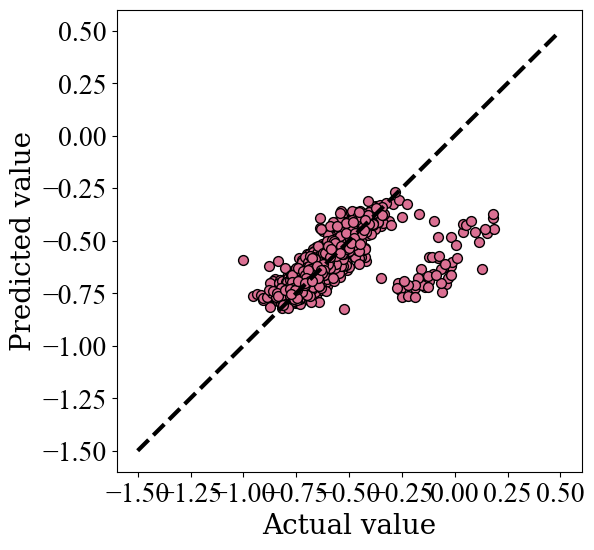

In [9]:
plt_figure(y_train_np,predicted_gp,-1.5,0.5)

In [21]:
X_train_re_index = X_train.reset_index(drop = True)
X_train_re_index.columns = columns_name
y_train_reindex = pd.DataFrame(y_train).reset_index(drop = True)
predicted_gp_pd = pd.DataFrame(predicted_gp)


In [23]:
columns_name_quan = ['Num.'] + [i for i in combinations] + ['Cr','Mn','Fe','Co','Ni','Cu','Cr','Mn','Fe','Co','Ni','Cu','y','pre']

In [26]:
data_pre_true = pd.concat([X_train_re_index,y_train_reindex,predicted_gp_pd],axis = 1)
data_pre_true.columns = columns_name_quan

In [27]:
data_pre_true.to_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/hcp/data_pre_true.xlsx')

In [4]:
data_fcc_de = pd.read_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/features/fcc/ML_delete_hcp_H.xlsx',index_col=0)
data_fcc_de

,Num.,"('Cr', 'Cr', 'Cr')","('Cr', 'Cr', 'Mn')","('Cr', 'Cr', 'Fe')","('Cr', 'Cr', 'Co')","('Cr', 'Cr', 'Ni')","('Cr', 'Cr', 'Cu')","('Cr', 'Mn', 'Mn')","('Cr', 'Mn', 'Fe')","('Cr', 'Mn', 'Co')",...,Co,Ni,Cu,Cr.1,Mn.1,Fe.1,Co.1,Ni.1,Cu.1,energy
0,alloy+H-0-26,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,-0.684893
1,alloy+H-0-36,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,1,0,0,-0.534637
2,alloy+H-0-37,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,-0.737187
3,alloy+H-0-38,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,-0.634500
4,alloy+H-0-39,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,-0.499132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831,alloy+H-24-104,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,-0.709497
1832,alloy+H-24-105,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.737570
1833,alloy+H-24-106,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,-0.711024
1834,alloy+H-24-107,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,-0.803050


In [5]:
X_pd1 = data_fcc_de.iloc[:,0:-1]
Y_pd1 = data_fcc_de.iloc[:,-1]

In [6]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(X_pd1,Y_pd1,test_size=0.2,random_state=0,shuffle=True)
X_train_pd1 = X_train1.iloc[:,1:]
X_test_pd1 = X_test1.iloc[:,1:]

X_train_np1 = np.array(X_train_pd1)
X_test_np1 = np.array(X_test_pd1)

y_train_np1 = np.array(y_train1)
y_test_np1 = np.array(y_test1)

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the kernel with ConstantKernel
kernel = ConstantKernel() * RBF() + WhiteKernel()

# Initialize the GaussianProcessRegressor
gp = GaussianProcessRegressor(kernel=kernel)

# Define the hyperparameter distributions
param_distributions = {
    "kernel__k1__k1__constant_value": np.logspace(-2, 1, 100)**2,
    "kernel__k1__k2__length_scale": np.logspace(-2, 2.5, 100),
    "kernel__k2__noise_level": np.logspace(-3, 0, 100)
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=gp, param_distributions=param_distributions, n_iter=30, cv=10, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_np1,y_train_np1)

# Print the best parameters
print(random_search.best_params_)
print(random_search.best_score_)

{'kernel__k2__noise_level': 0.8697490026177834, 'kernel__k1__k2__length_scale': 13.688745095370805, 'kernel__k1__k1__constant_value': 4.641588833612781}
0.620582218814609


In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 57.2236765935022 * RBF(length_scale=1.232846739442066) + WhiteKernel(noise_level=0.9326033468832199)

# 高斯过程回归模型
gp_test = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
score = cross_val_score(gp_test,X_train_np1,y_train_np1,cv=10,n_jobs=-1).mean()
mse = cross_val_score(gp_test,X_train_np1,y_train_np1,cv=10,n_jobs=-1, scoring = 'neg_mean_squared_error').mean()

print(score) # R2
print(mse)                  
print(np.sqrt(score))       
print(np.sqrt(abs(mse)))

0.6198003689545174
-0.003057855966909581
0.7872740113546981
0.055297883927954976


In [39]:
predicted_gp = cross_val_predict(gp_test,X_train_np1,y_train_np1, cv=10,n_jobs=-1)

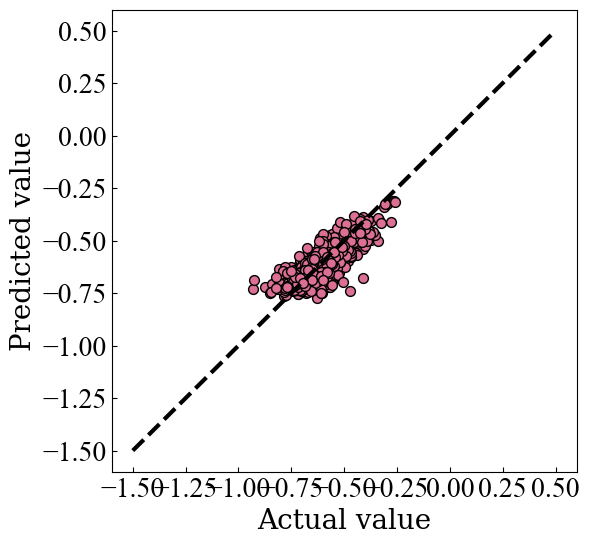

In [40]:
plt_figure(y_train_np1,predicted_gp,-1.5,0.5)

In [41]:
clf_xgb = gp_test.fit(X_train_np1,y_train_np1)
train_xgb = clf_xgb.predict(X_train_np1)
#X_test_pd_np_gbr = np.array(X_test_pd[index_])
#clf_mlpr.predict(X_test_stan_)
R2 = r2_score(y_train_np1,train_xgb)
mse = mean_squared_error(y_train_np1,train_xgb)
print(R2)
print(mse)
print(np.sqrt(score))       
print(np.sqrt(abs(mse)))

0.6786622149263362
0.0026813486750722018
0.7872740113546981
0.05178174074972955


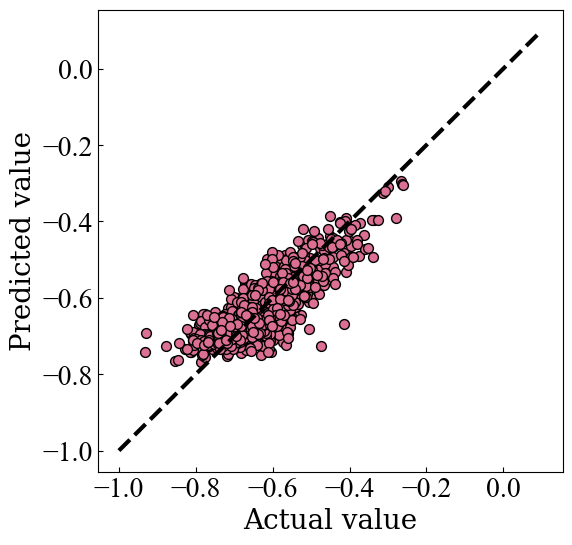

In [48]:
plt_figure(y_train_np1,train_xgb,-1,0.1)

In [42]:
#X_test_pd_np_gbr = np.array(X_test_pd[index_])
R2 = r2_score(y_test_np1,clf_xgb.predict(X_test_np1))
mse = mean_squared_error(y_test_np1,clf_xgb.predict(X_test_np1))
print(R2)
print(mse)
print(np.sqrt(score))       
print(np.sqrt(abs(mse)))

0.6798075543482796
0.0025910366568029706
0.7872740113546981
0.05090222644249435


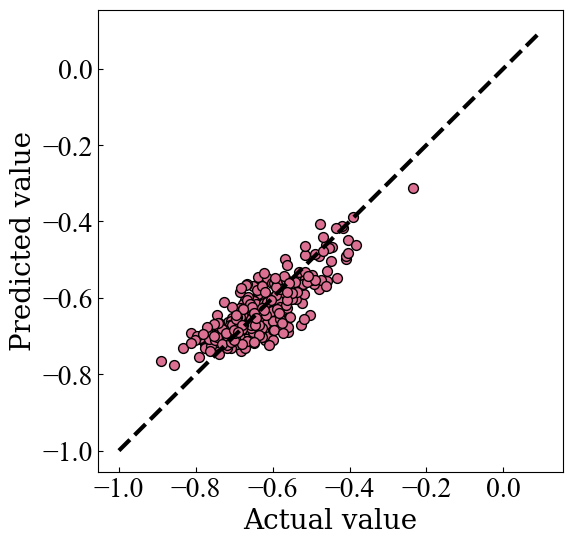

In [47]:
plt_figure(y_test_np1,clf_xgb.predict(X_test_np1),-1,0.1)

In [25]:
i = 24
j = 19
path_POSCAR = r'F:/work in tohoku/a_research_work/i_Nottingham_Ling/alloy+H-dft-POSCAR/' + 'POSCAR.' + str(int(i)) + '.' + str(int(j))
path_CONTCAR = r'F:/work in tohoku/a_research_work/i_Nottingham_Ling/HEA-H-CO-DFT-ref-data/alloy+H-dft-ref-data/alloy+H-dft-ref-data/' + 'CONTCAR.' + str(int(i)) + '.' + str(int(j))

In [26]:
structure_POSCAR = read(path_POSCAR)
super_structure_POSCAR = structure_POSCAR * (2, 2, 1)

structure_CONTCAR = read(path_CONTCAR)
super_structure_CONTCAR = structure_CONTCAR * (2, 2, 1)

In [30]:
view(super_structure_POSCAR)

<Popen: returncode: None args: ['D:\\Anaconda\\anzhuang\\python.exe', '-m', ...>

In [27]:
view(super_structure_CONTCAR)

<Popen: returncode: None args: ['D:\\Anaconda\\anzhuang\\python.exe', '-m', ...>

In [ ]:
H_positions,H_layer_index = H_position(super_structure_CONTCAR)
top_layer_index, second_layer_index,top_layer_atoms,second_layer_atoms = top_second_layer(super_structure_CONTCAR,all_atoms,metal_atoms,H_positions)        
adsorb_site_index, three_surround_index_name_distance = get_adsorb_site_surrounded_three(H_positions,top_layer_atoms,top_layer_index)        

In [ ]:
H_positions

In [ ]:
three_surround_index_name_distance

In [ ]:
super_structure_CONTCAR

In [ ]:
# 打印这些原子的坐标
position_three = []
three_index = []
for index_i in three_surround_index_name_distance:
    index = index_i[0]
    position = super_structure_CONTCAR[index].position
    position_three.append(position)
    three_index.append(index)

In [ ]:
three_index

In [ ]:
# 计算并打印两两之间的中点
def calculate_midpoint(position_three):
    midpoints = []
    for i in range(len(position_three)):
        for j in range(i + 1, len(position_three)):
            midpoint = (position_three[i]+position_three[j])/2
            midpoints.append(midpoint)
    return midpoints

In [ ]:
midpoints = calculate_midpoint(position_three)
midpoints

In [ ]:
def adsorb_H_index(super_structure,H_positions,H_layer_index):
    # 计算晶胞中心
    #cell_center = np.array(super_structure_CONTCAR.cell.diagonal()) / 2
    cell_center = np.mean(super_structure.cell, axis=0)
    # 计算每个氢原子到晶胞中心的距离
    distances_to_center = np.linalg.norm(H_positions - cell_center, axis=1)
    
    # 找到最近的氢原子
    closest_H_index = np.argmin(distances_to_center)
    closest_H_coords = H_positions[closest_H_index]
    adsorb_site_index = H_layer_index[closest_H_index]
    return adsorb_site_index,closest_H_coords

In [ ]:
second_three_atom_top_list = []
for i in range(len(midpoints)):
    midpoints_i = midpoints[i]
    distances_top = [np.linalg.norm(atom.position - midpoints_i) for atom in top_layer_atoms]
    sorted_indices = sorted(range(len(distances_top)), key=lambda j: distances_top[j])[0:4]
    nearest_atoms = [(top_layer_index[k], top_layer_atoms[k].symbol, distances_top[k]) for k in sorted_indices]
    for j in range(4):
        nearest_index = nearest_atoms[j][0]
        nearest_atom = nearest_atoms[j][1]
        if nearest_index in three_index:
            print('1')
            continue
        else:
            second_three_atom_top_list.append([nearest_index,nearest_atom])

In [ ]:
three_index

In [ ]:
from ase import Atoms
import numpy as np

H_coordinates = H_positions

# 计算晶胞中心
#cell_center = np.array(super_structure_CONTCAR.cell.diagonal()) / 2
cell_center = np.mean(super_structure_CONTCAR.cell, axis=0)
# 计算每个氢原子到晶胞中心的距离
distances_to_center = np.linalg.norm(H_coordinates - cell_center, axis=1)

# 找到最近的氢原子
closest_H_index = np.argmin(distances_to_center)
closest_H_coords = H_coordinates[closest_H_index]

print("最近的氢原子坐标:", closest_H_coords)


In [ ]:
H_layer_index

In [ ]:
distances_to_center

In [ ]:
second_nearest_atoms = get_surround_three_second(super_structure,second_layer_atoms,adsorb_site_index)
first_layer_first_atom = get_first_three(six_surround_index_name_distance)
first_layer_second_count = six_surround_index_name_distance[3:]        
atom_counts_1_layersecond_top = count_atom_number(first_layer_second_count) 
            
features = []
features.append('alloy+H-' +str(int(i)) + '-' + str(int(j)))
for m_i in range(len(combinations)):
    com_i = combinations[m_i]
    sorted_com_i = sorted(com_i)
    sorted_first_atom = sorted(first_layer_first_atom)
    if sorted_first_atom == sorted_com_i:
        features.append(1)
    else:
        features.append(0)   
                       
for m_k in metal_atoms:
    if m_k in atom_counts_1_layersecond_top:
        atom_count = atom_counts_1_layersecond_top[m_k]
        features.append(atom_count)
    else:
        features.append(0)
                        
           
diff_1_2_atom = abs(second_nearest_atoms[0][-1] - second_nearest_atoms[1][-1])
if diff_1_2_atom>0.2:
    second_layer_results = second_nearest_atoms[0]
    second_site = second_nearest_atoms[0][1]
    for m_j in metal_atoms:
        if m_j == second_site:
            features.append(1)
        else:
            features.append(0)
                        
elif diff_1_2_atom<0.2:
    second_layer_second = count_atom_number(second_nearest_atoms) 
    for m_j in metal_atoms:
        if m_j in second_layer_second:
            atom_count = second_layer_second[m_j]
            features.append(atom_count)
        else:
            features.append(0)

In [ ]:
data_feature_adsorp_fcc_final

In [ ]:
data_feature_adsorp_fcc_final.to_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/alloy+H-dft-POSCAR/data_feature_adsorp_fcc_final.xlsx')

In [ ]:
data_feature_adsorp_hcp_final = pd.DataFrame()
for feature_i in data_name_hcp_features_all:
    if feature_i in data_name_adsoption_energy_np:
        #data_feature = features_all[features_all['Num.'] ==feature_i]
        data_feature = features_hcp_all.loc[features_hcp_all['Num.'] == feature_i].copy()
        data_adsorb = data_adsoption_energy[data_adsoption_energy['# H adsorption energy in eV per H'] ==feature_i]['EH']
        data_adsorb_np = np.array(data_adsorb)
        data_feature.loc[:,'energy'] = data_adsorb_np
        #data_feature_adsorp = pd.concat([data_feature,data_adsorb],axis = 1,ignore_index=True)
        data_feature_adsorp_hcp_final = pd.concat([data_feature_adsorp_hcp_final,data_feature],axis = 0, ignore_index=True)
    else:
        continue

In [ ]:
data_feature_adsorp_hcp_final.to_excel('F:/work in tohoku/a_research_work/i_Nottingham_Ling/alloy+H-dft-POSCAR/data_feature_adsorp_hcp_final.xlsx')

In [ ]:
data_feature_adsorp_hcp_final

In [ ]:
X_pd = data_feature_adsorp_hcp_final.iloc[:,0:-1]
Y_pd = data_feature_adsorp_hcp_final.iloc[:,-1]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_pd,Y_pd,test_size=0.2,random_state=0,shuffle=True)
X_train_pd = X_train.iloc[:,1:]
X_test_pd = X_test.iloc[:,1:]

X_train_np = np.array(X_train_pd)
X_test_np = np.array(X_test_pd)

y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [ ]:
X_train

In [ ]:
import xgboost as xgb

In [ ]:
from xgboost import XGBRegressor
xgb_test =  XGBRegressor(n_estimators=500,
                        colsample_bytree=0.8,
                        #gamma=0.0,
                        max_depth=6,
                         min_child_weight = 4,
                         reg_alpha = 10,
                         reg_lambda = 1,
                         subsample = 0.8,
                        learning_rate=0.01,
                        random_state = 0,
                        n_jobs = 2) 
score = cross_val_score(xgb_test,X_train_np,y_train_np,cv=10).mean()
mse = cross_val_score(xgb_test,X_train_np,y_train_np,cv=10,scoring = 'neg_mean_squared_error').mean()

print(score) # R2
print(mse)                  
print(np.sqrt(score))       
print(np.sqrt(abs(mse)))

In [ ]:
predicted_xgb = cross_val_predict(xgb_test,X_train_np,y_train_np, cv=10,n_jobs=-1)

In [ ]:
plt_figure(y_train_np,predicted_xgb,-1.5,0.5)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 100.0**2 * RBF(length_scale=100.0) + WhiteKernel(noise_level=0.03162277660168379)

# 高斯过程回归模型
gp_test = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
score = cross_val_score(gp_test,X_train_np,y_train_np,cv=10,n_jobs=-1).mean()
mse = cross_val_score(gp_test,X_train_np,y_train_np,cv=10,n_jobs=-1, scoring = 'neg_mean_squared_error').mean()

print(score) # R2
print(mse)                  
print(np.sqrt(score))       
print(np.sqrt(abs(mse)))

In [ ]:
predicted_xgb = cross_val_predict(gp_test,X_train_np,y_train_np, cv=10,n_jobs=-1)

In [ ]:
plt_figure(y_train_np,predicted_xgb,-1.5,0.5)

In [ ]:
dtrain = xgb.DMatrix(X_train_np, label=y_train_np)
dtest = xgb.DMatrix(X_test_np, label=y_test_np)


In [ ]:


# 训练模型
bst = xgb.train(params, dtrain, num_boost_round=100)

# 预测
y_pred = bst.predict(dtest)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

In [ ]:
score = cross_val_score(xgb_test,X_train_np,y_train_np,cv=10).mean()

In [ ]:
data_feature_adsorp_fcc_final.head()

In [ ]:
data_feature_adsorp_fcc_final.shape

In [ ]:
X_com_pd = data_feature_adsorp_fcc_final.iloc[:,1:-1]

In [ ]:
com_list = []

# 遍历每一行并生成格式化的字符串
for index, row in data_com_pd.iterrows():
    formatted_str = ''
    for column in data_com_pd.columns:
        value = row[column]
        # 如果值大于0，则将其添加到格式化的字符串中
        if value > 0:
            formatted_str += f"{column}{value}"
    # 更新'Formatted'列的值
    com_list.append(formatted_str)


In [ ]:
X_com_pd.head()

In [ ]:
X_com_pd_i = X_com_pd.iloc[0,0:56]

In [ ]:
X_com_pd_i[X_com_pd_i != 0]

In [ ]:
X_com_pd.iterrows()

In [ ]:
def get_adsorb_site_surrounded_six(H_positions,top_layer_atoms,top_layer_index):
    adsorb_site_surrounded_six_all = []
    for i in range(len(H_positions)):  
        # 获取距离最近的六个原子的索引和距离
        distances_top = [np.linalg.norm(atom.position - H_positions[i]) for atom in top_layer_atoms]
        sorted_indices = sorted(range(len(distances_top)), key=lambda j: distances_top[j])[0:3]
        nearest_atoms = [(top_layer_index[k], top_layer_atoms[k].symbol, distances_top[k]) for k in sorted_indices]
        metal_surrd_adsorb = 0
        for m in range(len(nearest_atoms)):
            dis = nearest_atoms[m][-1]
            if dis < 2.5:
                metal_surrd_adsorb += 1
        if metal_surrd_adsorb == 3:
            adsorb_site_surrounded_six_all.append([H_layer_index[i],nearest_atoms])
    #if len(adsorb_site_surrounded_six) >= 1:  
    # adsorb_site_surrounded_six = adsorb_site_surrounded_six_all[0]
    # adsorb_site_index = adsorb_site_surrounded_six[0]
    # six_surround_index_name_distance = adsorb_site_surrounded_six[1]
    return adsorb_site_surrounded_six_all

In [ ]:
adsorb_site_surrounded_six_all = get_adsorb_site_surrounded_six(H_positions,top_layer_atoms,top_layer_index)

In [ ]:
adsorb_site_surrounded_six_all

In [ ]:
H_layer_index

In [ ]:
adsorb_site_surrounded_six_all = []
for i in range(len(H_positions)):  
    # 获取距离最近的六个原子的索引和距离
    print(i)
    distances_top = [np.linalg.norm(atom.position - H_positions[i]) for atom in top_layer_atoms]
    sorted_indices = sorted(range(len(distances_top)), key=lambda j: distances_top[j])[0:6]
    nearest_atoms = [(top_layer_index[k], top_layer_atoms[k].symbol, distances_top[k]) for k in sorted_indices]
    print(nearest_atoms)
    metal_surrd_adsorb = 0
    for m in range(len(nearest_atoms)):
        dis = nearest_atoms[m][-1]
        if dis < 3.8:
            metal_surrd_adsorb += 1
    if metal_surrd_adsorb == 6:
        adsorb_site_surrounded_six_all.append([H_layer_index[i],nearest_atoms])
    #if len(adsorb_site_surrounded_six) >= 1:  
adsorb_site_surrounded_six = adsorb_site_surrounded_six_all[0]
adsorb_site_index = adsorb_site_surrounded_six[0]
six_surround_index_name_distance = adsorb_site_surrounded_six[1]

In [ ]:
def get_adsorb_site_surrounded_three(closest_H_coords,top_layer_atoms,top_layer_index):
    adsorb_site_surrounded_three_all = []  
    distances_top = [np.linalg.norm(atom.position - closest_H_coords) for atom in top_layer_atoms]
    sorted_indices = sorted(range(len(distances_top)), key=lambda j: distances_top[j])[0:3]
    nearest_atoms_three = [(top_layer_index[k], top_layer_atoms[k].symbol, distances_top[k]) for k in sorted_indices]
    return nearest_atoms_three

In [ ]:
adsorb_site_surrounded_six_all

In [ ]:
adsorb_site_surrounded_six

In [ ]:
sorted_indices

In [ ]:
nearest_atoms

In [ ]:
adsorb_site_surrounded_six_all

In [ ]:
view(super_structure)

In [ ]:
structure = read('F:/work in tohoku/a_research_work/i_Nottingham_Ling/alloy+H-dft-POSCAR/POSCAR.0.1 ')

In [ ]:
super_structure = structure * (2, 2, 1)

In [ ]:
view(super_structure)

In [ ]:
super_structure = read('F:/work in tohoku/a_research_work/i_Nottingham_Ling/POSCAR00-repeat.vasp')

In [ ]:
write('F:/work in tohoku/a_research_work/i_Nottingham_Ling/POSCAR00-repeat.vasp', structure * (2, 2, 1), direct=False,sort=True)

In [ ]:
H_positions = H_position(super_structure)
H_layer_index = [i for i, atom in enumerate(super_structure) if atom.symbol == 'H']

In [ ]:
second_nearest_atoms[0][1]

In [ ]:
H_layer_index

In [ ]:
super_structure[0]

In [ ]:
H_positions

In [ ]:
top_layer_index, second_layer_index,top_layer_atoms,second_layer_atoms = top_second_layer(super_structure,all_atoms,metal_atoms,H_positions)

In [ ]:
len(top_layer_atoms)

In [ ]:
adsorb_site_index, six_surround_index_name_distance = get_adsorb_site_surrounded_six(H_positions,top_layer_atoms,top_layer_index)

In [ ]:
atom_list

In [ ]:
first_atom = atom_list[0:3]

In [ ]:
from itertools import combinations_with_replacement

metal_atoms = ['Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu']
combinations = list(combinations_with_replacement(metal_atoms, 3))

In [ ]:
adsorb_site_index

In [ ]:
feature_combinations = []
for i in range(len(combinations)):
    com_i = combinations[i]
    sorted_com_i = sorted(com_i)
    sorted_first_atom = sorted(first_atom)
    if sorted_first_atom == sorted_com_i:
        feature_combinations.append(1)
    else:
        feature_combinations.append(0)        

In [ ]:
pd.DataFrame(feature_combinations).T

In [ ]:
second_atom = atom_list[3:]

In [ ]:
count = six_surround_index_name_distance[3:]

In [ ]:
def count_atom_number(index_name_distance):
    atom_counts = {}
    # 遍历数据并统计每种原子的数量
    for item in index_name_distance:
        atom = item[1]  # 获取原子的符号
        if atom in atom_counts:
            atom_counts[atom] += 1  # 如果原子已经在字典中，则将计数加1
        else:
            atom_counts[atom] = 1  # 如果原子不在字典中，则将计数初始化为1
    return atom_counts

In [ ]:
atom_counts = count_atom_number(count)

In [ ]:
atom_counts

In [ ]:
for m_k in metal_atoms:
    if m_k in atom_counts_six_top:
        atom_count = atom_counts_six_top[m_k]
        features.append(atom_count)
    else:
        features.append(0)

In [ ]:
six_surround_index_name_distance

In [ ]:
second_nearest_atoms = get_surround_three_second(super_structure,second_layer_atoms,adsorb_site_index)

In [ ]:
second_nearest_atoms

In [ ]:
H_layer_index

In [ ]:
structure = read('F:/work in tohoku/a_research_work/i_Nottingham_Ling/alloy+H-dft-POSCAR/POSCAR.18.64')

In [ ]:
super_structure = structure * (2, 2, 1)

In [ ]:
view (super_structure)

In [ ]:
H_positions = H_position(super_structure)
H_layer_index = [i for i, atom in enumerate(super_structure) if atom.symbol == 'H']

In [ ]:
top_layer_index, second_layer_index,top_layer_atoms,second_layer_atoms = top_second_layer(super_structure,all_atoms,metal_atoms,H_positions)

In [ ]:
adsorb_site_index, six_surround_index_name_distance = get_adsorb_site_surrounded_six(H_positions,top_layer_atoms,top_layer_index)        
second_nearest_atoms = get_surround_three_second(super_structure,second_layer_atoms,adsorb_site_index)
first_layer_first_atom = get_first_three(six_surround_index_name_distance)
first_layer_second_count = six_surround_index_name_distance[3:]        
atom_counts_1_layersecond_top = count_atom_number(first_layer_second_count) 

In [ ]:
second_nearest_atoms